##### Loading the desired libraries

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from keras.models import Sequential
from keras.layers import Flatten ,Dropout,Dense,Activation
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import Conv2D,GlobalAveragePooling2D,MaxPooling2D,ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import cv2

##### Loading the data
The data is stored in .p extension which is a pickle file.

`“Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream is converted back into an object hierarchy. Pickling (and unpickling) is alternatively known as “serialization”, “marshaling,” or “flattening” .`

Test and Training data can be downloaded from here : https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip

In [142]:
##Loading the Data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file ,mode='rb') as f:
    train =pickle.load(f)

with open(testing_file ,mode='rb') as f:
    test =pickle.load(f)

x_train ,y_train = train['features'] ,train['labels']
x_test ,y_test = test['features']  ,test['labels']

In [143]:
print(x_train.shape ,y_train.shape)
print(x_test.shape ,y_test.shape)

(39209, 32, 32, 3) (39209,)
(12630, 32, 32, 3) (12630,)


In [144]:
## unique classes stores the distinct labels
## unique_sign    stores the distinct classes labels
## unique_sign_counts stores the count of each label in the dataset

unique_classes,unique_sign ,unique_sign_counts=np.unique(y_train ,return_index =True ,return_counts=True)
print(unique_classes)
print(unique_sign)
print(unique_sign_counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[    0   210  2430  4680  6090  8070  9930 10350 11790 13200 14670 16680
 18000 20100 22260 23040 23670 24090 25200 26400 26610 26970 27300 27690
 28200 28470 29970 30570 30810 31350 31620 32070 32850 33090 33779 34199
 35399 35789 35999 38069 38369 38729 38969]
[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160
  780  630  420 1110 1200  210  360  330  390  510  270 1500  600  240
  540  270  450  780  240  689  420 1200  390  210 2070  300  360  240
  240]


#### Data Plotting and Exploration

In [29]:
def plot_images():
    
    fig = plt.figure(figsize=(18,18))
    i=0
    for index in (unique_sign):
        #     ax.set_xticklabels([])
        #     ax.set_yticklabels([])
        #     ax.set_aspect('equal')
        img =x_train[index]
        plt.subplot(11,4,i+1)
        plt.imshow(img)
        plt.title( str(y_train[index]))
        plt.axis('off')
        i =i+1
    plt.show()

In [160]:
from PIL import Image
for ind in range(unique_sign[35],unique_sign[35]+30):
    img = x_train[ind]
    img = Image.fromarray(img)
    img.save(str(ind) + "test.jpeg")

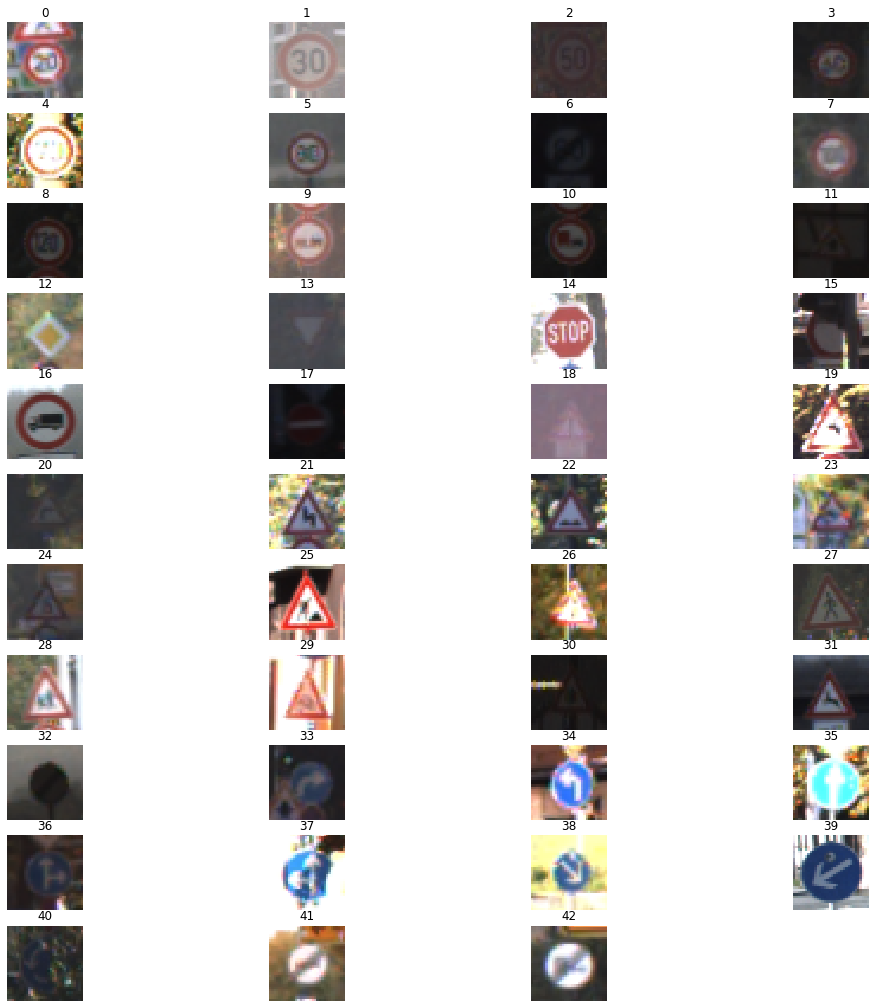

In [30]:
import matplotlib.image as img
plot_images()

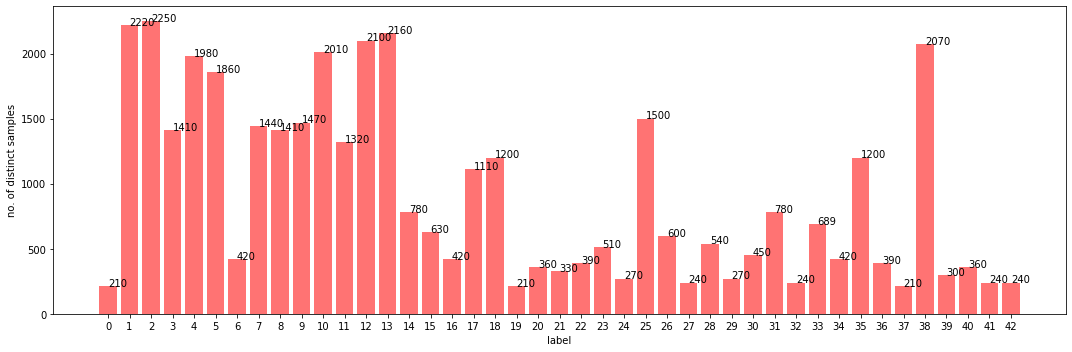

In [31]:
## plotting histogram

plt.figure(figsize=(15,5))
plt.bar(unique_classes,unique_sign_counts ,color='r' ,alpha=0.55)
plt.xlabel('label')
plt.ylabel('no. of distinct samples')
plt.xticks(unique_classes)
for a,b in zip(unique_classes ,unique_sign_counts):
    plt.text(a, b, str(b))
plt.tight_layout()
plt.show()

### Data Preprocessing

Preprocessing includes normalization ,filtering noise , rescaling , dimension reduction of the images for better accuracy.

Here we will be using open cv2 library to normalize the images between 50 to 200  through MIN-MAX scaling.

1.Normalization will mitigate differences due to light condition across the data set and will make the pixel intesity consistant.

2.Image Blurring or (Image Smoothing) :

Bluring is done to remove noise/unwanted features. Median blur was choosen because it works good in removing salt and pepper noise and produces best results when tested in comparison with averaging, gaussian blur or bilateralFilter.

understanding source : https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html


In [32]:
## preprocessing and scaling of data
import cv2
def normailze_blur(img):
    img = cv2.normalize(img, img, 50,200 ,cv2.NORM_MINMAX)
    cv2.medianBlur(img, 3)                                 ##here 30% noise is added to the original dataset and applied median blur on it
    return img

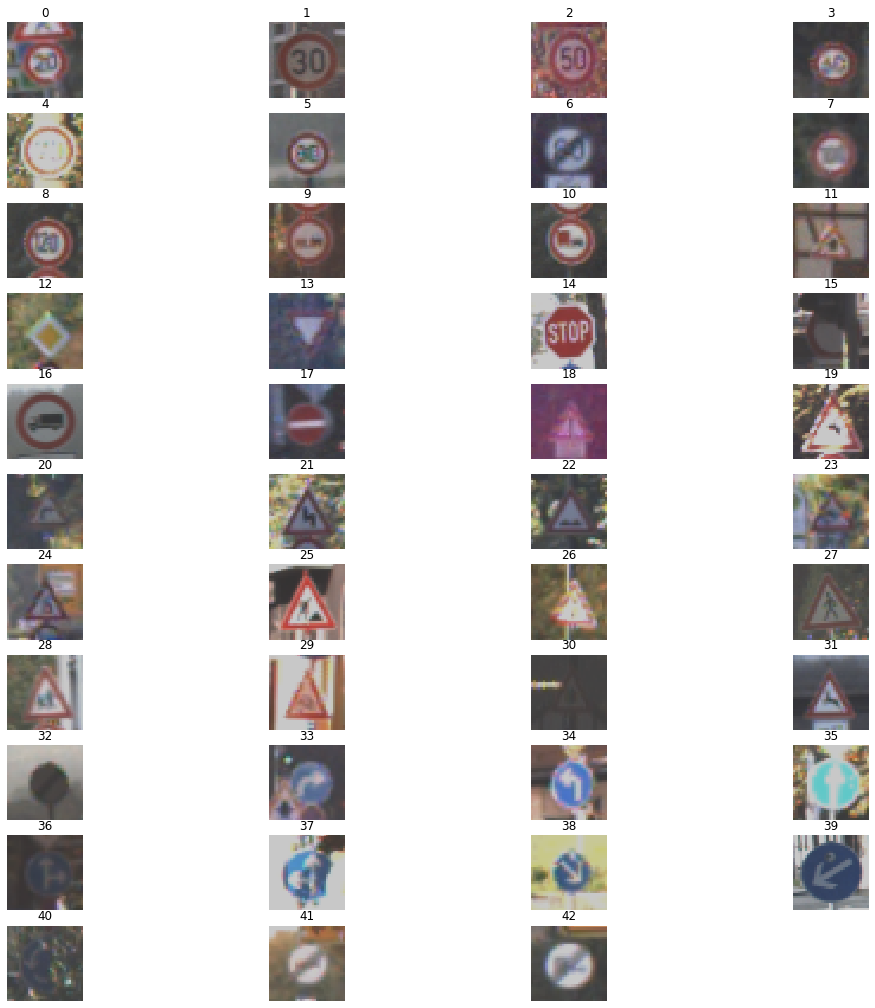

In [148]:
for i in range(len(x_train)):
    normailze_blur(x_train[i])

for i in range(len(x_test)):
    normailze_blur(x_test[i])

## Plotting the normalized dataset
## clearly the are normalized on a given scale.
plot_images()

##### Data Split into Train and Validation set

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

x_train ,y_train = shuffle(x_train,y_train)
x_test ,y_test =shuffle(x_test,y_test)

In [35]:
X_train , X_validation ,Y_train ,Y_validation =train_test_split(x_train,y_train,shuffle=True,random_state=0,test_size=0.3)

###### One-hot encoding of the output as needed in the CNN network

In [36]:
## one hot of the output
def one_hotencode(data):
    return np_utils.to_categorical(data,len(unique_classes))     # unique_classes here ,are 42

In [37]:
Y_train = one_hotencode(Y_train)
Y_validation =one_hotencode(Y_validation)
y_test =one_hotencode(y_test)

In [64]:
X_train.shape , X_validation.shape, Y_train.shape

((27446, 32, 32, 3), (11763, 32, 32, 3), (27446, 43))

##### Defining the state of art (CNN) architecutre .

specifying the Conv2D layers , hidden ,flatten layers

In [39]:
## specifying the layers
model =Sequential()

model.add(Conv2D(32,(5,5),strides=(1,1) ,input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32 ,(5,5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(64,(5,5)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis =-1))

model.add(Conv2D(64 ,(5,5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(1024))
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(len(unique_classes)))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [40]:
model.compile(loss='categorical_crossentropy' ,optimizer=Adam() ,metrics=['accuracy'])

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
__________

#### Data Augmentation
Data Augmentation is certainly a better way to get most out of the few or small dataset.

Here Data Augmentation can certainly improve the accuracy of the network as rotating the image to a certain angle will not change the defined 'knowldege' or quality of the physical nature of the images.

In [42]:
##Data augementation
##This network is paired using the Keras ImageDataGenerator to assist with image Augmentation through the learning process. 
##This can greatly improve the accuracy without the increase of labelled training examples.

gen = ImageDataGenerator(rotation_range=13 ,width_shift_range=0.12 ,shear_range=0.3 ,height_shift_range=0.12,zoom_range=0.2)
train_generator =gen.flow(X_train,Y_train,batch_size=32)

In [43]:
validate_gen =ImageDataGenerator()

validate_generator =validate_gen.flow(X_validation ,Y_validation)

#### Training the Model

In [44]:
model.fit_generator(train_generator ,steps_per_epoch=27446//20 ,epochs=7 ,
                    validation_data =validate_generator,validation_steps =11763//80)

Instructions for updating:
Use tf.cast instead.
Epoch 1/7
1372/1372 [==============================] - 183s 133ms/step - loss: 1.3047 - acc: 0.6460 - val_loss: 0.1398 - val_acc: 0.9611
Epoch 2/7
1372/1372 [==============================] - 177s 129ms/step - loss: 0.3225 - acc: 0.9018 - val_loss: 0.6700 - val_acc: 0.8493
Epoch 3/7
1372/1372 [==============================] - 182s 132ms/step - loss: 0.2106 - acc: 0.9379 - val_loss: 0.0990 - val_acc: 0.9712
Epoch 4/7
1372/1372 [==============================] - 193s 141ms/step - loss: 0.1612 - acc: 0.9525 - val_loss: 0.0916 - val_acc: 0.9747
Epoch 5/7
1372/1372 [==============================] - 189s 138ms/step - loss: 0.1551 - acc: 0.9547 - val_loss: 0.0371 - val_acc: 0.9872
Epoch 6/7
1372/1372 [==============================] - 190s 138ms/step - loss: 0.1235 - acc: 0.9657 - val_loss: 0.0682 - val_acc: 0.9797
Epoch 7/7
1372/1372 [==============================] - 191s 139ms/step - loss: 0.1054 - acc: 0.9694 - val_loss: 0.0119 - val_acc: 

In [22]:
x_test.shape ,y_test.shape

((12630, 32, 32, 3), (12630, 43))

###### Evaluating the accuracy metrics of the model

In [45]:
accuracy = model.evaluate(x_test,y_test)

12630/12630 [==============================] - 9s 734us/step


In [46]:
accuracy 

[0.1283660191563489, 0.9702296120348377]

In [47]:
model.save("TrafficSignModel.h5")

In [133]:
from keras.models import load_model
loaded_model = load_model('TrafficSignModel.h5')
accuracy = loaded_model.evaluate(x_test,y_test)
accuracy

12630/12630 [==============================] - 10s 807us/step


[0.1283660191563489, 0.9702296120348377]

In [141]:
for ind in unique_sign:
    img = x_train[ind]
    y = np.argmax(loaded_model.predict(img.reshape((1,32,32,3))))
    print(y, y_train[ind])

3 3
10 10
18 18
4 4
2 2
38 38
1 1
27 27
8 8
1 1
22 22
8 8
9 9
1 1
12 12
5 5
35 35
35 35
39 39
17 17
4 4
17 17
17 17
10 10
4 4
10 10
15 15
22 22
2 2
25 25
3 3
10 10
17 17
31 31
38 38
2 2
33 33
39 39
2 2
5 5
2 2
38 38
2 2


In [116]:
#Both heavy coins must have same weight
def TwoHeavy(arr,T):
    print(arr)
    if arr.shape[0] <= 1:
        print("Something's wrong, I can feel it. Time",T)
        return
    if arr.shape[0] == 2:
        print("Found with Time",T)
        return
    n = arr.shape[0]
    a = arr[0 : int(n/3)]
    b = arr[int(n/3) : 2*int(n/3)]
    c = arr[2*int(n/3) : 3*int(n/3)]
    d = arr[3*int(n/3) : n]
    if sum(a) > sum(b):
        if sum(a) > sum(c): return TwoHeavy(np.append(a,d), T+2)
        if sum(a) == sum(c): return TwoHeavy(np.append(a,c), T+2)
    if sum(a) < sum(b):
        if sum(b) > sum(c): return TwoHeavy(np.append(b,d), T+2)
        if sum(b) == sum(c): return TwoHeavy(np.append(b,c), T+2)
    if sum(a) == sum(b):
        if sum(b) > sum(c): return TwoHeavy(np.append(a,b), T+2)
        if sum(b) < sum(c): return TwoHeavy(np.append(c,d), T+2)
        if sum(b) == sum(c): return TwoHeavy(d, T+2)
    return
        
n = (27,5,6)#input("Enter n and n1,n2").split(" ")
a = np.full_like(np.arange(int(n[0]),dtype=int),10)
a[int(n[1])] = 15
a[int(n[2])] = 15
TwoHeavy(a,0)

[10 10 10 10 10 15 15 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10]
[10 10 10 10 10 15 15 10 10]
[10 10 15 15 10 10]
[15 15]
Found with Time 6


In [114]:
# Difference of heavy coin from original is greater than diffrence of light coin from original
def OneHeavyOneLight(arr,T):
    print(arr)
    if arr.shape[0] <= 1:
        print("Something's wrong, I can feel it. Time",T)
        return
    if arr.shape[0] == 2:
        print("Found with Time",T)
        return
    n = arr.shape[0]
    a = arr[0 : int(n/3)]
    b = arr[int(n/3) : 2*int(n/3)]
    c = arr[2*int(n/3) : 3*int(n/3)]
    d = arr[3*int(n/3) : n]
    if sum(a) > sum(b):
        if sum(a) > sum(c):
            if sum(b) > sum(c): return OneHeavyOneLight(np.append(a,c),T+3)
            if sum(b) < sum(c): return OneHeavyOneLight(np.append(a,b),T+3)
            if sum(b) == sum(c): return OneHeavyOneLight(np.append(a,d),T+3) 
        
        if sum(a) < sum(c): return OneHeavyOneLight(np.append(b,c),T+2)
        if sum(a) == sum(c): return OneHeavyOneLight(np.append(b,d),T+2) 
    
    if sum(a) < sum(b):
        if sum(b) > sum(c):
            if sum(a) > sum(c): return OneHeavyOneLight(np.append(b,c),T+3) 
            if sum(a) < sum(c): return OneHeavyOneLight(np.append(b,a),T+3) 
            if sum(a) == sum(c): return OneHeavyOneLight(np.append(b,d),T+3) 
        
        if sum(b) < sum(c): return OneHeavyOneLight(np.append(a,c),T+2) 
        if sum(b) == sum(c): return OneHeavyOneLight(np.append(a,d),T+2) 
    
    if sum(a) == sum(b):
        if sum(a) > sum(c): return OneHeavyOneLight(np.append(d,c),T+2) 
        if sum(a) < sum(c): return OneHeavyOneLight(np.append(d,c),T+2) 
        if sum(a) == sum(c): return OneHeavyOneLight(d,T+2) 
    return
        
n = (25,20,7)#input("Enter n and n1,n2").split(" ")
a = np.full_like(np.arange(int(n[0]),dtype=int),10)
a[int(n[1])] = 15
a[int(n[2])] = 8
OneHeavyOneLight(a,0)

[10 10 10 10 10 10 10  8 10 10 10 10 10 10 10 10 10 10 10 10 15 10 10 10
 10]
[10 10 10 10 10 10 10  8 10 10 10 10 15 10 10 10]
[10 10  8 10 10 10 10 15 10 10]
[10 10  8 10 15 10]
[ 8 10 15 10]
[ 8 15]
Found with Time 10


In [130]:
#Minimum number of coins are 5 to check for 2 counterfeit
#We will be checking each coin one by one with the original coin
def TwoCounterfeit(arr,T):
    original = -1
    for i in range(2,arr.shape[0]):
        if arr[i-2]==arr[i-1] and arr[i-1]==arr[i]:
            T+=2
            original = i
            break
    c=0
    for i in range(0,original-2):
        T+=1
        if arr[i]!=arr[original]: c+=1
        if c==2: break
    if c==2: print("Found with Time",T)
    else:
        for i in range(original+1, arr.shape[0]):
            T+=1
            if arr[i]!=arr[original]: c+=1
            if c==2: break
        if c!=2: print("Something's wrong, I can feel it. Time",T)
        if c==2: print("Found with Time",T)
    return

n = (25,0,1)#input("Enter n and n1,n2").split(" ")
a = np.full_like(np.arange(int(n[0]),dtype=int),10)
a[int(n[1])] = 15
a[int(n[2])] = 5
TwoCounterfeit(a,0)

Found with Time 4
